In [3]:
# !pip install --user matplotlib seaborn

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1


In [6]:
from tensorflow.keras.models import load_model

In [7]:
from bert.layers import Attention, Transformer, DenseNoMask
from bert.optimizers import ECE, masked_sparse_categorical_crossentropy

In [8]:
# log = pd.read_csv('/scratch/pstjohn/transformer_base_512_checkpoints/log.csv')

In [9]:
model = load_model('/scratch/pstjohn/lr4_single_node_checkpoints/ckpt.h5', 
                   custom_objects={
                       'Transformer': Transformer,
                       'Attention': Attention,
                       'DenseNoMask': DenseNoMask,
                       'masked_sparse_categorical_crossentropy': masked_sparse_categorical_crossentropy,
                       'ECE': ECE})

In [10]:
from bert.dataset import create_masked_input_dataset

valid_data = create_masked_input_dataset(
    sequence_path='../uniparc_data/sequences_valid.txt',
    max_sequence_length=256,
    batch_size=48)

In [11]:
masked_seq, true_values = next(iter(valid_data))
ECE(true_values, model.predict(masked_seq))

<tf.Tensor: id=16864, shape=(), dtype=float32, numpy=14.604922>

In [12]:
predictions = tf.nn.softmax(model.predict(masked_seq))

In [13]:
masked_entries = tf.not_equal(true_values, 0)
y_true_mask = tf.boolean_mask(true_values, masked_entries)
y_pred_mask = tf.boolean_mask(predictions, masked_entries)

In [14]:
import pandas as pd

In [15]:
aas = ['0', 'MASK', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
confusion_mat = pd.DataFrame(y_pred_mask.numpy()).groupby(y_true_mask.numpy()).sum()
confusion_mat.columns = aas
confusion_mat.index = aas[2:]

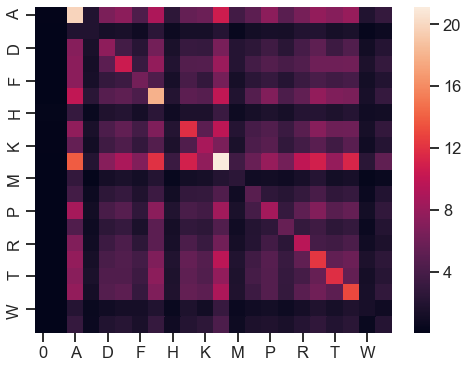

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mat)

In [22]:
model.layers

In [ ]:
embeddings

In [69]:
inputs = tf.keras.Model(model.layers[0].input, model.layers[1].output)(masked_seq)

In [37]:
transformer = model.layers[-2]

In [72]:
self = transformer.attention_layer

qk = self.transpose_scores(self.qk_layer(inputs))  # [B,N,S,H]
value = self.transpose_scores(self.value_layer(inputs))  # [B,N,S,H]

# generate a_ij^K and a_ij^K from, Shaw et al. 2018 arXiv:1803.02155
length = tf.shape(inputs)[1]  # B, S, N*H
relative_positions = self._generate_relative_positions_matrix(length)
relations_keys = self.relations_keys_embedding(relative_positions)       

# Eq. 4 of arXiv:1803.02155
attention_scores = self._relative_attention_inner(qk, qk, relations_keys, True) 
attention_scores = attention_scores / tf.sqrt(float(self.units))  # [B,N,S,S]

In [109]:
mask = inputs._keras_mask
attention_mask = self.create_attention_mask(mask)
attention_scores_mask = attention_scores + (1. - attention_mask) * -10000.0
attention_probs = tf.nn.softmax(attention_scores_mask)  # [B,N,S,S]
context_layer = tf.matmul(attention_probs, value)  # [B,N,S,S]

input_shape  = tf.shape(inputs)
output_shape = [input_shape[0], input_shape[1], self.num_heads*self.units]
# context_layer = tf.reshape(context_layer, output_shape)

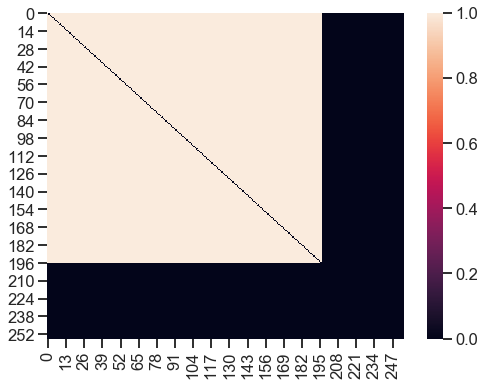

In [93]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_mask[3, 0].numpy())

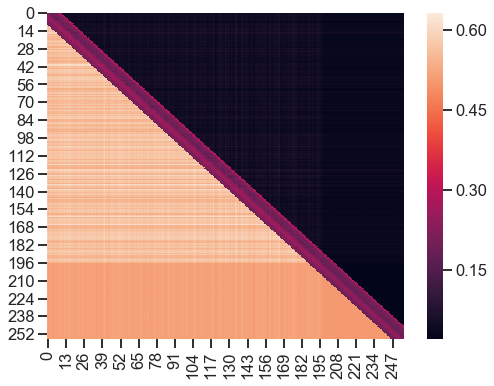

In [97]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_scores[3, 0].numpy())

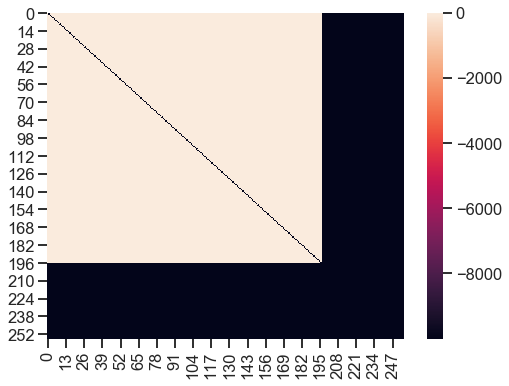

In [99]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_scores_mask[3, 0].numpy())

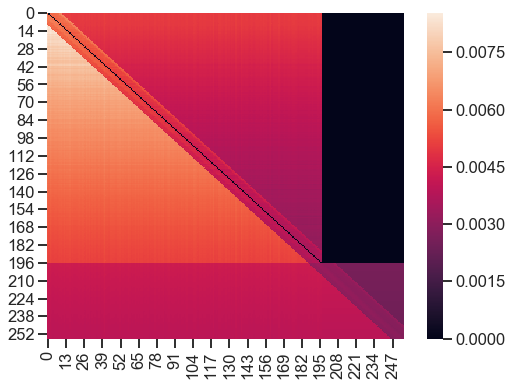

In [101]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_probs[3, 0].numpy())

In [108]:
context_layer.shape

TensorShape([48, 256, 512])

In [111]:
context_layer.shape

TensorShape([48, 8, 256, 64])

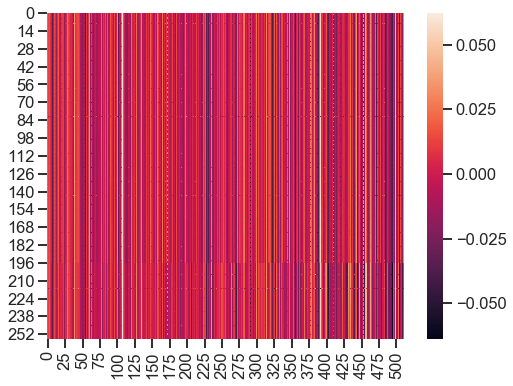

In [114]:
plt.figure(figsize=(8,6))
sns.heatmap(tf.reshape(tf.transpose(a=context_layer, perm=[0, 2, 1, 3]), input_shape)[3].numpy())